# <center><span style="color:DarkBlue">과제 5: 모델링2</span></center> <a class="tocSkip">

2017.12.1~2018.10.31 까지의 따릉이 대여량 및 날씨, 계절, 기온 등의 데이터를 기반으로 2018년 11월 공공자전거 대여량 예측하기

### 변수 설명
- Date : 대여 날짜(MM/DD/YY)
- Rented Bike Count : 시간대별 자전거 대여량 / `종속변수`
- Hour : 대여 시간(0시~23시)
- Temperature : 온도(°C)
- Humidity : 습도(%)
- Wind speed : 풍속(m/s)
- Visibility : 가시거리(10m)
- Dew point temperature : 이슬점(°C)
- Solar Radiation : 일사량(MJ/m2)
- Rainfall : 강수량(mm)
- Snowfall : 적설량(cm)
- Seasons : 계절
- Holiday : 공휴일 유무
- Functioning day : 운영일 유무

### 라이브러리 불러오기

In [60]:
#!pip install xgboost

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# 결측치 확인하는 라이브러리
import missingno as msno 

# 다중대체 라이브러리
from fancyimpute import IterativeImputer

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

(CVXPY) Feb 14 06:19:53 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: 지정된 모듈을 찾을 수 없습니다.')
(CVXPY) Feb 14 06:19:53 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: 지정된 모듈을 찾을 수 없습니다.')
(CVXPY) Feb 14 06:19:53 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: 지정된 모듈을 찾을 수 없습니다.')


In [3]:
# Window의 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

### 데이터 불러오기
1차 전처리를 마친 train & test dataset 불러오기

In [4]:
# working directory 확인
os.getcwd() #현재 작업 위치 출력

'C:\\Users\\82105\\비어플\\과제'

In [5]:
# train dataset 불러오기
ttareung_train = pd.read_csv('ttareung_clean.csv')
train = ttareung_train.copy()

In [6]:
train

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week,Day
0,2017-12-01 00:00:00,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 00:00:00,12,Friday,1
1,2017-12-01 00:00:00,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 01:00:00,12,Friday,1
2,2017-12-01 00:00:00,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 02:00:00,12,Friday,1
3,2017-12-01 00:00:00,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 03:00:00,12,Friday,1
4,2017-12-01 00:00:00,78,4,-6.0,36,0.9,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 04:00:00,12,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7812,2018-10-31 00:00:00,1507,19,8.4,53,1.8,2000,-0.6,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 19:00:00,10,Wednesday,31
7813,2018-10-31 00:00:00,1176,20,7.6,59,0.7,2000,0.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 20:00:00,10,Wednesday,31
7814,2018-10-31 00:00:00,1069,21,7.6,59,3.0,1929,0.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 21:00:00,10,Wednesday,31
7815,2018-10-31 00:00:00,1088,22,6.8,58,2.2,1936,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 22:00:00,10,Wednesday,31


In [7]:
# 데이터 구조 확인
print(train.shape)
display(train.head())
display(train.tail())
train.info()

(7817, 18)


,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week,Day
0,2017-12-01 00:00:00,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 00:00:00,12,Friday,1
1,2017-12-01 00:00:00,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 01:00:00,12,Friday,1
2,2017-12-01 00:00:00,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 02:00:00,12,Friday,1
3,2017-12-01 00:00:00,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 03:00:00,12,Friday,1
4,2017-12-01 00:00:00,78,4,-6.0,36,0.9,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01 04:00:00,12,Friday,1


,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week,Day
7812,2018-10-31 00:00:00,1507,19,8.4,53,1.8,2000,-0.6,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 19:00:00,10,Wednesday,31
7813,2018-10-31 00:00:00,1176,20,7.6,59,0.7,2000,0.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 20:00:00,10,Wednesday,31
7814,2018-10-31 00:00:00,1069,21,7.6,59,3.0,1929,0.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 21:00:00,10,Wednesday,31
7815,2018-10-31 00:00:00,1088,22,6.8,58,2.2,1936,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 22:00:00,10,Wednesday,31
7816,2018-10-31 00:00:00,798,23,6.4,60,1.8,1930,-0.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-10-31 23:00:00,10,Wednesday,31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   7817 non-null   object 
 1   Rented Bike Count      7817 non-null   int64  
 2   Hour                   7817 non-null   int64  
 3   Temperature            7817 non-null   float64
 4   Humidity               7817 non-null   int64  
 5   Wind speed             7817 non-null   float64
 6   Visibility             7817 non-null   int64  
 7   Dew point temperature  7817 non-null   float64
 8   Solar Radiation        7817 non-null   float64
 9   Rainfall               7817 non-null   float64
 10  Snowfall               7817 non-null   float64
 11  Seasons                7817 non-null   object 
 12  Holiday                7817 non-null   object 
 13  Functioning Day        7817 non-null   object 
 14  Datetime               7817 non-null   object 
 15  Mont

In [8]:
train.isna().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
Datetime                 0
Month                    0
Day_of_Week              0
Day                      0
dtype: int64

=> 결측치가 없는 것을 확인할 수 있음.

In [9]:
# test dataset 불러오기
ttareung_test = pd.read_csv('ttareung_clean_test.csv')
test = ttareung_test.copy()

In [10]:
test

,Date,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week
0,2018-11-01 00:00:00,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 00:00:00,11,Thursday
1,2018-11-01 00:00:00,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 01:00:00,11,Thursday
2,2018-11-01 00:00:00,2,4.4,64,1.6,2000,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 02:00:00,11,Thursday
3,2018-11-01 00:00:00,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 03:00:00,11,Thursday
4,2018-11-01 00:00:00,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 04:00:00,11,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2018-11-30 00:00:00,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 19:00:00,11,Friday
644,2018-11-30 00:00:00,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 20:00:00,11,Friday
645,2018-11-30 00:00:00,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 21:00:00,11,Friday
646,2018-11-30 00:00:00,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 22:00:00,11,Friday


In [11]:
# 데이터 구조 확인
print(test.shape)
display(test.head())
display(test.tail())
test.info()

(648, 16)


,Date,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week
0,2018-11-01 00:00:00,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 00:00:00,11,Thursday
1,2018-11-01 00:00:00,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 01:00:00,11,Thursday
2,2018-11-01 00:00:00,2,4.4,64,1.6,2000,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 02:00:00,11,Thursday
3,2018-11-01 00:00:00,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 03:00:00,11,Thursday
4,2018-11-01 00:00:00,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 04:00:00,11,Thursday


,Date,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week
643,2018-11-30 00:00:00,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 19:00:00,11,Friday
644,2018-11-30 00:00:00,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 20:00:00,11,Friday
645,2018-11-30 00:00:00,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 21:00:00,11,Friday
646,2018-11-30 00:00:00,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 22:00:00,11,Friday
647,2018-11-30 00:00:00,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-30 23:00:00,11,Friday


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   648 non-null    object 
 1   Hour                   648 non-null    int64  
 2   Temperature            648 non-null    float64
 3   Humidity               648 non-null    int64  
 4   Wind speed             648 non-null    float64
 5   Visibility             648 non-null    int64  
 6   Dew point temperature  648 non-null    float64
 7   Solar Radiation        648 non-null    float64
 8   Rainfall               648 non-null    float64
 9   Snowfall               648 non-null    float64
 10  Seasons                648 non-null    object 
 11  Holiday                648 non-null    object 
 12  Functioning Day        648 non-null    object 
 13  Datetime               648 non-null    object 
 14  Month                  648 non-null    int64  
 15  Day_of

In [12]:
test.isna().sum()

Date                     0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
Datetime                 0
Month                    0
Day_of_Week              0
dtype: int64

=> 결측치가 없는 것을 확인할 수 있음.

In [13]:
# test 셋에 Day 변수 생성하기
test['Date'] = pd.to_datetime(test['Date'])
test['Day'] = test['Date'].dt.day
test.head()

,Date,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week,Day
0,2018-11-01,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 00:00:00,11,Thursday,1
1,2018-11-01,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 01:00:00,11,Thursday,1
2,2018-11-01,2,4.4,64,1.6,2000,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 02:00:00,11,Thursday,1
3,2018-11-01,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 03:00:00,11,Thursday,1
4,2018-11-01,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 04:00:00,11,Thursday,1


## 2차 전처리
- 범주형 데이터 수치화
- 변수 선택
- train, valid, test 셋 분리 
- 변수 스케일링

### 1. 범주형 데이터 수치화

(1) 명목형 변수 : Seasons, Holiday 원핫인코딩

In [14]:
# 객체 생성
ohe = OneHotEncoder(sparse_output=False)

#데이터프레임에 학습하고 변환
result_ohe = ohe.fit_transform(train[['Seasons','Holiday']])
result_ohe

array([[0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       ...,
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.]])

In [15]:
ohe.categories_

[array(['Autumn', 'Spring', 'Summer', 'Winter'], dtype=object),
 array(['Holiday', 'No Holiday'], dtype=object)]

In [16]:
#result_ohe는 numpy.array이므로 데이터프레임으로 변환
df_ohe = pd.DataFrame(result_ohe, columns=ohe.get_feature_names_out(['Seasons','Holiday']))
df_ohe

,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday
0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...
7812,1.0,0.0,0.0,0.0,0.0,1.0
7813,1.0,0.0,0.0,0.0,0.0,1.0
7814,1.0,0.0,0.0,0.0,0.0,1.0
7815,1.0,0.0,0.0,0.0,0.0,1.0


In [17]:
# 원래의 train 데이터와 병합
train = pd.concat([train, df_ohe], axis=1)
train.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,...,Datetime,Month,Day_of_Week,Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday
0,2017-12-01 00:00:00,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,2017-12-01 00:00:00,12,Friday,1,0.0,0.0,0.0,1.0,0.0,1.0
1,2017-12-01 00:00:00,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,2017-12-01 01:00:00,12,Friday,1,0.0,0.0,0.0,1.0,0.0,1.0
2,2017-12-01 00:00:00,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,2017-12-01 02:00:00,12,Friday,1,0.0,0.0,0.0,1.0,0.0,1.0
3,2017-12-01 00:00:00,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,2017-12-01 03:00:00,12,Friday,1,0.0,0.0,0.0,1.0,0.0,1.0
4,2017-12-01 00:00:00,78,4,-6.0,36,0.9,2000,-18.6,0.0,0.0,...,2017-12-01 04:00:00,12,Friday,1,0.0,0.0,0.0,1.0,0.0,1.0


In [18]:
# test 셋에 대해서도 동일하게 원핫인코딩 적용
result_ohe = ohe.fit_transform(test[['Seasons','Holiday']])
result_ohe

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [19]:
ohe.categories_

[array(['Autumn'], dtype=object), array(['No Holiday'], dtype=object)]

In [20]:
#result_ohe는 numpy.array이므로 데이터프레임으로 변환
df_ohe2 = pd.DataFrame(result_ohe, columns=ohe.get_feature_names_out(['Seasons','Holiday']))
df_ohe2

,Seasons_Autumn,Holiday_No Holiday
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
643,1.0,1.0
644,1.0,1.0
645,1.0,1.0
646,1.0,1.0


In [21]:
# 원래의 test 데이터와 병합
test = pd.concat([test, df_ohe2], axis=1)
test.head()

,Date,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Datetime,Month,Day_of_Week,Day,Seasons_Autumn,Holiday_No Holiday
0,2018-11-01,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 00:00:00,11,Thursday,1,1.0,1.0
1,2018-11-01,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 01:00:00,11,Thursday,1,1.0,1.0
2,2018-11-01,2,4.4,64,1.6,2000,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 02:00:00,11,Thursday,1,1.0,1.0
3,2018-11-01,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 03:00:00,11,Thursday,1,1.0,1.0
4,2018-11-01,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018-11-01 04:00:00,11,Thursday,1,1.0,1.0


In [22]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   7817 non-null   object 
 1   Rented Bike Count      7817 non-null   int64  
 2   Hour                   7817 non-null   int64  
 3   Temperature            7817 non-null   float64
 4   Humidity               7817 non-null   int64  
 5   Wind speed             7817 non-null   float64
 6   Visibility             7817 non-null   int64  
 7   Dew point temperature  7817 non-null   float64
 8   Solar Radiation        7817 non-null   float64
 9   Rainfall               7817 non-null   float64
 10  Snowfall               7817 non-null   float64
 11  Seasons                7817 non-null   object 
 12  Holiday                7817 non-null   object 
 13  Functioning Day        7817 non-null   object 
 14  Datetime               7817 non-null   object 
 15  Mont

(2) 순서형 변수 : Day_of_Week 라벨인코딩

In [23]:
# 수치 맵핑
# Monday : 0
# Tuesday :1
# Wednesday :2
# Thursday : 3
# Friday : 4
# Saturday : 5
# Sunday : 6

train['dow_encoded'] = train['Day_of_Week'].map({'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6})
test['dow_encoded'] = test['Day_of_Week'].map({'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6})

In [24]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   7817 non-null   object 
 1   Rented Bike Count      7817 non-null   int64  
 2   Hour                   7817 non-null   int64  
 3   Temperature            7817 non-null   float64
 4   Humidity               7817 non-null   int64  
 5   Wind speed             7817 non-null   float64
 6   Visibility             7817 non-null   int64  
 7   Dew point temperature  7817 non-null   float64
 8   Solar Radiation        7817 non-null   float64
 9   Rainfall               7817 non-null   float64
 10  Snowfall               7817 non-null   float64
 11  Seasons                7817 non-null   object 
 12  Holiday                7817 non-null   object 
 13  Functioning Day        7817 non-null   object 
 14  Datetime               7817 non-null   object 
 15  Mont

### 2. 변수 선택

In [25]:
# 필요없는 열 제거
train = train.drop(['Date','Seasons','Holiday','Functioning Day','Datetime','Day_of_Week'], axis=1)
test = test.drop(['Date','Seasons','Holiday','Functioning Day','Datetime','Day_of_Week'], axis=1)

In [26]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rented Bike Count      7817 non-null   int64  
 1   Hour                   7817 non-null   int64  
 2   Temperature            7817 non-null   float64
 3   Humidity               7817 non-null   int64  
 4   Wind speed             7817 non-null   float64
 5   Visibility             7817 non-null   int64  
 6   Dew point temperature  7817 non-null   float64
 7   Solar Radiation        7817 non-null   float64
 8   Rainfall               7817 non-null   float64
 9   Snowfall               7817 non-null   float64
 10  Month                  7817 non-null   int64  
 11  Day                    7817 non-null   int64  
 12  Seasons_Autumn         7817 non-null   float64
 13  Seasons_Spring         7817 non-null   float64
 14  Seasons_Summer         7817 non-null   float64
 15  Seas

### 3. train, valid, test 셋 분리
따릉이 과제용 데이터에는 test 파일이 따로 있으므로 train_test_split을 한 번만 해주면 됨

In [27]:
# X(독립변수), y(종속변수) 분리
X = train.drop('Rented Bike Count', axis=1)
y = train['Rented Bike Count']

In [28]:
# train과 valid 셋 분리
# 8 : train, 2 : valid

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6253, 18) (1564, 18) (6253,) (1564,)


### 4. 변수 스케일링
일반적으로 스케일링을 하면 모델의 성능이 더 좋아지지만, 트리계열의 경우 꼭 필요한 단계는 아니다. 그래도 4가지 스케일링 방법 모두 해보기

(1) Standard Scaler

In [29]:
#객체 생성
ss = StandardScaler()

#학습 및 변환
X_train_ss = ss.fit_transform(X_train) #fit은 꼭 train에서만 사용해야 함.
X_val_ss = ss.transform(X_val)
#X_test_ss = ss.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'평균: {X_train_ss.mean()}\n분산: {X_train_ss.std()}')
print("<valid 셋>")
print(f'평균: {X_val_ss.mean()}\n분산: {X_val_ss.std()}')

<train 셋>
평균: -1.1552616579073008e-17
분산: 0.9999999999999999
<valid 셋>
평균: -0.0037758095983081532
분산: 0.9845005845269539


(2) MinMax Scaler

In [30]:
#객체 생성
mms = MinMaxScaler()

#학습 및 변환
X_train_mms = mms.fit_transform(X_train)
X_val_mms = mms.transform(X_val)
#X_test_mms = mms.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'최대: {X_train_mms.max()}\n최소: {X_train_mms.min()}')
print("<valid 셋>")
print(f'최대: {X_val_mms.max()}\n최소: {X_val_mms.min()}')

<train 셋>
최대: 1.0000000000000002
최소: 0.0
<valid 셋>
최대: 1.0
최소: -0.005272407732864692


(3) MaxAbs Scaler

In [31]:
#객체 생성
mas = MaxAbsScaler()

#학습 및 변환
X_train_mas = mas.fit_transform(X_train)
X_val_mas = mas.transform(X_val)
#X_test_mas = mas.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'최대: {X_train_mas.max()}\n최소: {X_train_mas.min()}')
print("<valid 셋>")
print(f'최대: {X_val_mas.max()}\n최소: {X_val_mas.min()}')

<train 셋>
최대: 1.0
최소: -1.0
<valid 셋>
최대: 1.0
최소: -0.9705882352941175


(4) Robust Scaler

In [32]:
#객체 생성
rs = RobustScaler()

#학습 및 변환
X_train_rs = rs.fit_transform(X_train)
X_val_rs = rs.transform(X_val)
#X_test_rs = rs.transform(X_test) #test셋이 있는 경우

print("<train 셋>")
print(f'평균: {X_train_rs.mean()}\n분산: {X_train_rs.std()}')
print("<valid 셋>")
print(f'평균: {X_val_rs.mean()}\n분산: {X_val_rs.std()}')
#중앙값과 사분위값을 보는 게 정석이긴 함. 

<train 셋>
평균: 0.0811271239781046
분산: 0.6355564574747662
<valid 셋>
평균: 0.07634968721641743
분산: 0.6007775963150361


## 모델 학습
- Decision Tree
- Random Forest
- XGBoost
- Linear Regression

### 1. Decision Tree
- 구조가 단순하여 해석이 쉬움
- 분류, 회귀 문제 모두 사용 가능하며 가장 기본이 되는 모델

(1) 모델 선언

In [33]:
model1=DecisionTreeRegressor(random_state=42)

In [34]:
# 하이퍼파라미터 확인하기
print(model1.get_params())

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


(2) 모델 학습

In [35]:
model1.fit(X_train, y_train).get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

(3) 모델 평가

In [43]:
pred = model1.predict(X_val) # 검증 데이터의 예측값

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.847495
MAE: 138.969309
MSE: 62128.519182
RMSE: 249.255931


### 2. Random Forest
- 여러 개의 의사결정나무 모델을 만들어 학습하고 각 모델의 평균값으로 결과를 산출
- 단일 Decision Tree에 비해 성능이 뛰어남
- 과적합 문제를 최소화하여 모델의 정확도를 높일 수 있어서 사용

(1) 모델 선언

In [44]:
model2 = RandomForestRegressor(random_state=42)

In [38]:
# 하이퍼파라미터 확인하기
print(model2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


(2) 모델 학습

In [46]:
model2.fit(X_train, y_train).get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

(3) 모델 평가

In [47]:
pred = model2.predict(X_val) # 검증 데이터의 예측값

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.932332
MAE: 98.421611
MSE: 27567.247297
RMSE: 166.033874


### 3. XGBoost
- 비록 많은 메모리를 소모하지만 트리 기반의 앙상블 학습 모델로 높은 성능을 보임
- 이전 트리의 오차를 보완해 새로운 트리를 만들어나가는 방식

(1) 모델 선언

In [48]:
model3 = XGBRegressor(random_state=42)

In [64]:
# 하이퍼파라미터 확인하기
print(model3.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


(2) 모델 학습

In [49]:
model3.fit(X_train, y_train).get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

(3) 모델 평가

In [50]:
pred = model3.predict(X_val) # 검증 데이터의 예측값

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.944011
MAE: 94.286453
MSE: 22809.292997
RMSE: 151.027458


### 4. Linear Regression
- 종속변수 y 1개와 1개 이상의 독립변수 X 사이의 선형상관관계를 모델링
- 간단하고 빠르며 이해하기 쉬움
- 조정해야할 매개변수의 수가 적음
- 데이터 스케일링의 영향을 받으므로 위에서 실행한 스케일링 방법을 적용해보기

#### 4.1 스케일링 X

(1) 모델 선언

In [54]:
model4 = LinearRegression()

(2) 모델 학습

In [55]:
model4.fit(X_train, y_train).get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

(3) 모델 평가

In [56]:
pred = model4.predict(X_val) # 검증 데이터의 예측값

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.542063
MAE: 327.366447
MSE: 186557.935835
RMSE: 431.923530


#### 4.2 Standard Scaling

In [58]:
# 모델 선언
model5 = LinearRegression()

# 모델 학습
model5.fit(X_train_ss, y_train)

# 모델 평가
pred = model5.predict(X_val_ss)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.542063
MAE: 327.366447
MSE: 186557.935835
RMSE: 431.923530


#### 4.3 Min-Max Scaling

In [61]:
# 모델 선언
model6 = LinearRegression()

# 모델 학습
model6.fit(X_train_mms, y_train)

# 모델 평가
pred = model6.predict(X_val_mms)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.542063
MAE: 327.366447
MSE: 186557.935835
RMSE: 431.923530


#### 4.4 MaxAbs Scaling

In [62]:
# 모델 선언
model7 = LinearRegression()

# 모델 학습
model7.fit(X_train_mas, y_train)

# 모델 평가
pred = model7.predict(X_val_mas)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.542063
MAE: 327.366447
MSE: 186557.935835
RMSE: 431.923530


#### 4.5 Robust Scaling

In [63]:
# 모델 선언
model8 = LinearRegression()

# 모델 학습
model8.fit(X_train_rs, y_train)

# 모델 평가
pred = model8.predict(X_val_rs)

r_squared = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred) # 오차에 절댓값을 취한 뒤 평균을 구함 -> 오차에 대해 똑같은 가중치가 부여
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) # 오차의 제곱의 평균값에 제곱근을 취함 -> 각각의 오차에 대해 가중치가 반영됨

# 따라서 RMSE는 오차가 클수록 페널티를 부여하기 때문에 MAE에 비해 이상치에 민감하다.

print("R^2: %f" % (r_squared))
print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

R^2: 0.542063
MAE: 327.366447
MSE: 186557.935835
RMSE: 431.923530


=> 4가지 변수 스케일링 방법을 가지고 선형회귀모델을 다시 돌려봤지만, 스케일링 전과 모델 성능 지표가 동일하게 나타났다.

- 4가지 모델 중, XGBoost가 R^2의 값이 0.944로 가장 높았으며, MAE와 RMSE의 값이 제일 작은 것으로 나타났다. 
- 따라서 XGBoost에 대해 하이퍼파라미터 튜닝 해보기

## 하이퍼파라미터 튜닝

XGBRegressor의 하이퍼파라미터
- n_estimators : 트리의 개수
- learning_rate : 학습률
- max_depth : 트리의 최대 깊이
- subsample : 각 트리 모델 학습 시 사용되는 샘플 데이터의 비율
- colsample_bytree : 각 트리 모델 학습 시 사용되는 특성(feature) 데이터의 비율

In [67]:
model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [69]:
# GridSearch
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [73]:
# 최적의 하이퍼파라미터 출력
from math import sqrt
print(sqrt(abs(gs.best_score_)))
print("최적의 하이퍼파라미터:", gs.best_params_)

154.58538419533764
최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


=> 기본 모델의 RMSE이 약 151이었으므로, 기본 모델에 비해 성능이 오히려 떨어짐.

ManualSearch를 통해 수동으로 하이퍼파라미터 조정하기

In [74]:
ms_model = XGBRegressor(random_state=42, n_estimators= 200, max_depth= 9)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 84.941540
MSE: 22515.793801
RMSE: 150.052637


In [81]:
ms_model = XGBRegressor(random_state=42, n_estimators= 300, max_depth= 9)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 84.928972
MSE: 22509.900153
RMSE: 150.032997


In [82]:
ms_model = XGBRegressor(random_state=42, n_estimators= 300, max_depth=9, learning_rate=0.1)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 81.705490
MSE: 21169.422230
RMSE: 145.497155


In [90]:
ms_model = XGBRegressor(random_state=42, n_estimators= 300, max_depth=9, learning_rate=0.05)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 80.642281
MSE: 20655.797691
RMSE: 143.721250


In [89]:
ms_model = XGBRegressor(random_state=42, n_estimators= 200, max_depth=7, learning_rate=0.1)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 83.303791
MSE: 19370.564444
RMSE: 139.178175


In [101]:
ms_model = XGBRegressor(random_state=42, n_estimators= 200, max_depth=7, learning_rate=0.05, subsample=0.8)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 82.046933
MSE: 18856.093574
RMSE: 137.317492


In [105]:
ms_model = XGBRegressor(random_state=42, n_estimators= 200, max_depth=8, learning_rate=0.05, subsample=0.8)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 79.568791
MSE: 18249.573288
RMSE: 135.090982


In [112]:
ms_model = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8)

# 모델 학습

ms_model.fit(X_train, y_train)

# 모델 평가
pred = ms_model.predict(X_val) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 77.186899
MSE: 17452.446570
RMSE: 132.107708


#### 기본 모델 
- MAE: 94.286453
- MSE: 22809.292997
- RMSE: 151.027458

=> 기본 모델에 비해 ManualSearch를 통해 하이퍼파라미터 튜닝을 한 결과, 성능이 더 좋아짐.

## 변수 중요도

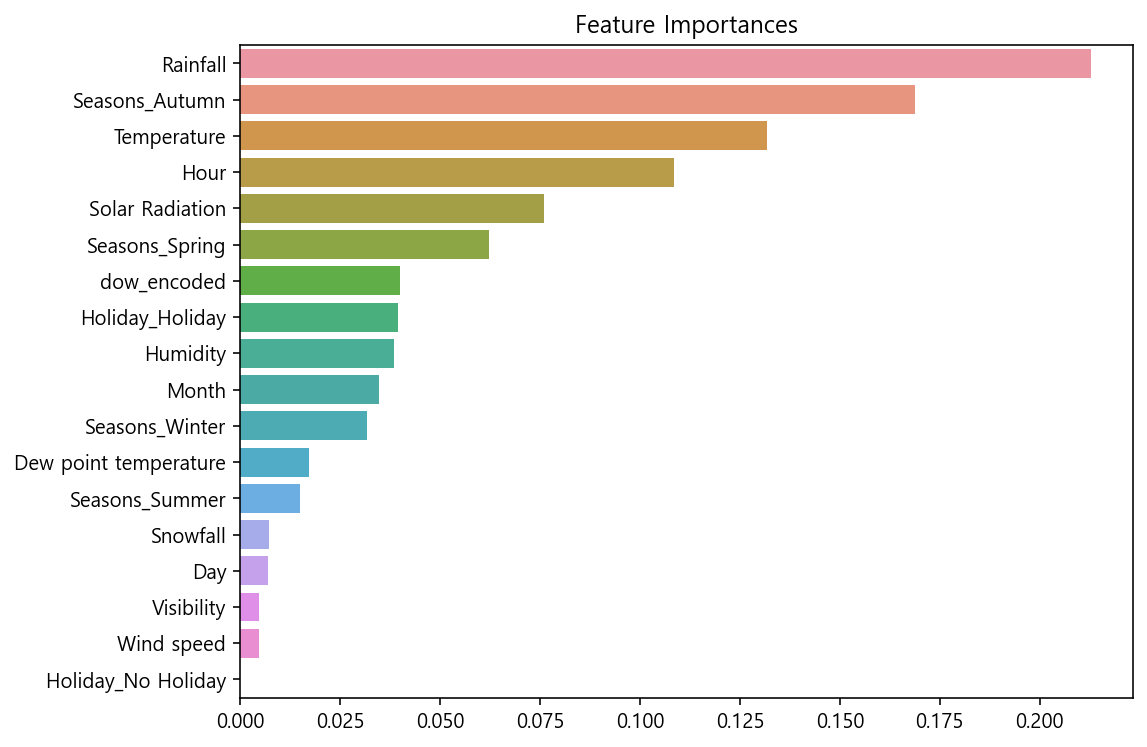

In [113]:
# 변수 중요도 계산

importances_values = pd.Series(ms_model.feature_importances_, index=X_val.columns).sort_values(ascending=False)

# 변수 중요도 시각화

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=importances_values, y=importances_values.index)
plt.show()

- Rainfall, Seasons_Autumn, Temperature 순으로 변수 중요도가 높음.
- 강수량이 따릉이 대여량에 가장 큰 영향을 미치는 것으로 보아, 비가 많이 오는 날과 그렇지 않은 날을 구분하여 자전거 배치가 필요해보임.
- 사계절 중 가을이 대여량에 가장 큰 영향을 미치므로, 계절(온도)에 따라 자전거 배치가 필요해보임.

변수 중요도가 낮은 변수를 제거한 뒤 다시 모델 돌려보기

In [128]:
# Snowfall부터 Holiday_No Holiday 까지를 제외하고 상위 13개의 변수만 가지고 재진행
top_n = 13

selected_features = importances_values.head(top_n).index.tolist()
#selected_features

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

In [129]:
model_re = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8) 

# 모델 학습
model_re.fit(X_train_selected, y_train)

# 모델 평가
pred = model_re.predict(X_val_selected) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 85.955292
MSE: 21252.840077
RMSE: 145.783538


=> RMSE 값이 하이퍼파라미터 튜닝 결과 값에 비해 오히려 더 커졌음.

In [130]:
# Visibility부터 Holiday_No Holiday 까지를 제외하고 상위 15개 변수만 가지고 재진행
top_n = 15

selected_features = importances_values.head(top_n).index.tolist()
#selected_features

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

In [131]:
model_re = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8) 

# 모델 학습
model_re.fit(X_train_selected, y_train)

# 모델 평가
pred = model_re.predict(X_val_selected) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 77.052323
MSE: 17884.329919
RMSE: 133.732307


=> RMSE 값이 하이퍼파라미터 튜닝 결과 값에 비해 오히려 더 커졌음.

In [132]:
# Holiday_No Holiday만 제외하고 상위 17개 변수만 가지고 재진행
top_n = 17

selected_features = importances_values.head(top_n).index.tolist()
#selected_features

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

In [133]:
model_re = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8) 

# 모델 학습
model_re.fit(X_train_selected, y_train)

# 모델 평가
pred = model_re.predict(X_val_selected) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 77.354258
MSE: 17729.633428
RMSE: 133.152670


=> RMSE 값이 하이퍼파라미터 튜닝 결과 값에 비해 오히려 더 커졌음.

In [134]:
# Dew point temperature부터 Holiday_No Holiday 까지를 제외하고 상위 11개 변수만 가지고 재진행
top_n = 11

selected_features = importances_values.head(top_n).index.tolist()
#selected_features

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

In [135]:
model_re = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8) 

# 모델 학습
model_re.fit(X_train_selected, y_train)

# 모델 평가
pred = model_re.predict(X_val_selected) # 검증 데이터의 예측값

mae = mean_absolute_error(y_val, pred) 
mse = mean_squared_error(y_val, pred) 
rmse = np.sqrt(mean_squared_error(y_val, pred)) 

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))
print("RMSE: %f" % (rmse))

MAE: 89.170968
MSE: 22390.016015
RMSE: 149.632938


=> RMSE 값이 하이퍼파라미터 튜닝 결과 값에 비해 오히려 더 커졌음.

## 최종모델
test 예측

In [145]:
X_test = test.copy()

In [147]:
X_train.columns

Index(['Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility',
       'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall',
       'Month', 'Day', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Holiday_Holiday', 'Holiday_No Holiday',
       'dow_encoded'],
      dtype='object')

In [148]:
X_test.columns

Index(['Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility',
       'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall',
       'Month', 'Day', 'Seasons_Autumn', 'Holiday_No Holiday', 'dow_encoded'],
      dtype='object')

In [149]:
# X_train의 칼럼 중 X_test에 없는 칼럼 찾기
missing_columns = set(X_train.columns) - set(X_test.columns)

# X_test에 누락된 칼럼 추가하고 0으로 초기화
for column in missing_columns:
    X_test[column] = 0

In [153]:
X_test = X_test[X_train.columns]

In [154]:
# 최종 모델
final_model = XGBRegressor(random_state=42, n_estimators= 300, max_depth=8, learning_rate=0.05, subsample=0.8)

# 모델 학습
final_model.fit(X_train, y_train)

# test 데이터로 예측
test['Rented Bike Count'] = final_model.predict(X_test)

In [155]:
test

,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Month,Day,Seasons_Autumn,Holiday_No Holiday,dow_encoded,Rented Bike Count
0,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,11,1,1.0,1.0,3,548.186218
1,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,11,1,1.0,1.0,3,456.568420
2,2,4.4,64,1.6,2000,-1.8,0.0,0.0,0.0,11,1,1.0,1.0,3,367.102295
3,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,11,1,1.0,1.0,3,293.418732
4,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,11,1,1.0,1.0,3,253.405090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,11,30,1.0,1.0,4,1062.115967
644,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,11,30,1.0,1.0,4,930.304626
645,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,11,30,1.0,1.0,4,975.431580
646,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,11,30,1.0,1.0,4,910.244812


In [158]:
# 최종 csv 파일 저장하기
test.to_csv('test_final.csv', index=False)